# Regressor Performance Analysis

## Introduction

This notebook guides through the analysis of an existing ML regressor. The performance evaluation is based on the R^2 score from sklearn and cross validation. The correlation of measured and predicted expression values is plotted. The feature importance from tree-based regressions represent the contributions of each nucleotide-position and the GC content to the prediction. They are extracted and visualized with a Logo-plot.

## System initiation

Loading all necessary libraries.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt
import joblib
import pickle
from math import sqrt
import sys
sys.path.append('..')
from exp2ipynb import *
from sklearn.model_selection import cross_val_score, GroupShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, plot_confusion_matrix, classification_report, f1_score, matthews_corrcoef
from sklearn.tree import export_graphviz
import pydot
%matplotlib inline


Matplotlib is building the font cache; this may take a moment.


### Variable setting

We load the naming conventions from 'config.txt'

In [2]:
Name_Dict = init_Exp2('config_Pput.txt')

File_Base = Name_Dict['Data_File'].split('.')[0]
Data_Folder = 'data-{}'.format(File_Base) 
ML_Date = Name_Dict['ML_Date']
ML_Regressor = Name_Dict['ML_Regressor'][:-1]
ML_Type = Name_Dict['ML_Regressor'][-1]
Y_Col_Name = eval(Name_Dict['Y_Col_Name'])
Response_Value = eval(Name_Dict['Response_Value'])

Already existent data directory  data-Example1-Pput .


## Loading training data

In [3]:
TrainTest_File = os.path.join(Data_Folder, '{}_{}_{}_TrainTest-Data.pkl'.format(ML_Date, File_Base, Response_Value))
TrainTest_Data = pickle.load(open(TrainTest_File,'rb'))
SeqTrain, SeqTest = TrainTest_Data['Train'], TrainTest_Data['Test']
print('Taining set size: {}'.format(len(SeqTrain)))
print('Test set size: {}'.format(len(SeqTest)))

Taining set size: 56
Test set size: 7


## Regressor analysis

In [4]:
# Loading the correct scoring for regression and classification
if Response_Value > 1:
    my_score = make_scorer(f1_score, average='weighted') # (matthews_corrcoef)(f1_score, average='weighted')
else:
    my_score = make_scorer(r2_score)
    
# Number of independent promoter library measurements
Measure_Numb = int(Name_Dict['Library_Expression'])
ML_Best = dict()
Expr_Scaler = dict()
mydtype = 'int8' if Response_Value > 1 else 'object' 
Y_train = np.empty((SeqTrain.shape[0], Measure_Numb), dtype=mydtype)
Y_train_pred = np.empty((SeqTrain.shape[0], Measure_Numb), dtype=mydtype)
Y_test = np.empty((SeqTest.shape[0], Measure_Numb), dtype=mydtype)
Y_test_pred = np.empty((SeqTest.shape[0], Measure_Numb), dtype=mydtype)
CVsplit = 25
scores = np.empty((CVsplit, Measure_Numb))

r2_train = np.empty(Measure_Numb)
r2_test = np.empty(Measure_Numb)
# rmse_train = np.empty(Measure_Numb)
# rmse_test = np.empty(Measure_Numb)
for Meas_Idx in range(Measure_Numb): 
    Measure_Name = '{}_ML'.format(Y_Col_Name[Meas_Idx])
    # loading correct ML regressor file and parameters for data preparation
    Regressor_File = os.path.join(Data_Folder, '{}_{}_{}_{}{}-Regressor.pkl'.format(ML_Date, File_Base, Measure_Name.replace(' ','-'), ML_Regressor, Response_Value))
    Parameter_File = os.path.join(Data_Folder, '{}_{}_{}_{}{}-Params.pkl'.format(ML_Date, File_Base, Measure_Name.replace(' ','-'), ML_Regressor, Response_Value))
#     if ML_Type == 'C':
#         YCol = '{}_Cat'.format(Y_Col_Name[Meas_Idx])
#     else:
#         YCol = Y_Col_Name[Meas_Idx]

    try:
#         ML_DictName = (Measure_Name)
        ML_Best[Measure_Name] = joblib.load(Regressor_File)
        # I assume the parameters have been generated in the same run as the regressor itself and is located in the same directory following the default naming scheme
        Data_Prep_Params = pickle.load(open(Parameter_File,'rb'))
        # extracting the positions that were removed because of insufficient information content
        Positions_removed = Data_Prep_Params['Positions_removed']
        # if the data was standardized we load the corresponding function
        if Response_Value == 0:
            # loading standard scaler
            Scaler_File = os.path.join(Data_Folder, '{}_{}_{}-Scaler.pkl'.format(time.strftime('%Y%m%d'), File_Base, Name_Dict['ML_Regressor']))
            Expr_Scaler = pickle.load(open(Scaler_File,'rb'))
            # The standard scaler default name is the name of the expression measurement column with suffix: '_Scaler'
            Scaler_DictName = '{}_Scaler'.format(Y_Col_Name[Meas_Idx])
#             Expr_Scaler[Scaler_DictName] = Data_Prep_Params[Scaler_DictName]
    except FileNotFoundError:
        print('Regressor file not found. Check parameter "ML_Date" in "config.txt"')

    X_tmp = list_onehot(list(np.delete(np.array(list(SeqTrain['Sequence_label-encrypted'])),Positions_removed, axis=1)))
    X_train = np.array(X_tmp).reshape(len(SeqTrain.index),-1)
    AddFeat = eval(Name_Dict['Add_Feat'])
    # adding the additional feature, here GC-content
    X_train = np.append(X_train,SeqTrain[AddFeat].values, axis=1)
    # activity prediction of training set with best random forest estimator
    Y_train_pred[:,Meas_Idx] = ML_Best[Measure_Name].predict(X_train)
    # correcting the prediction for standardized data
#     if eval(Name_Dict['Data_Standard']):
#         Y_train_pred[:,Meas_Idx] = Expr_Scaler[Scaler_DictName].inverse_transform(Y_train_pred[:,Meas_Idx])

    # Test set prediction
    # removing sequence positions that were missing in the feature vector for ml
    # getting one-hot encodings from the original train and test data
    X_tmp = list_onehot(list(np.delete(np.array(list(SeqTest['Sequence_label-encrypted'])),Positions_removed, axis=1)))
    X_test = np.array(X_tmp).reshape(len(SeqTest.index),-1)
    # adding the additional feature, here GC-content
    X_test = np.append(X_test,SeqTest[AddFeat].values, axis=1)
    # activity prediction of training set with best random forest estimator
    Y_test_pred[:,Meas_Idx] = ML_Best[Measure_Name].predict(X_test)
    # correcting the prediction for standardized data
#     if eval(Name_Dict['Data_Standard']):
#         Y_test_pred[:,Meas_Idx] = Expr_Scaler[Scaler_DictName].inverse_transform(Y_test_pred[:,Meas_Idx])

    # corresponding observations scaled
#     Scaler_DictName = '{}_Scaler'.format(Y_Col_Name[Meas_Idx])
    Y_train[:, Meas_Idx] = SeqTrain[Measure_Name].values
    Y_test[:, Meas_Idx] = SeqTest[Measure_Name].values

    r2_train[Meas_Idx] = r2_score(Y_train[:, Meas_Idx], Y_train_pred[:, Meas_Idx])
    r2_test[Meas_Idx] = r2_score(Y_test[:, Meas_Idx], Y_test_pred[:, Meas_Idx])
#     rmse_train[Meas_Idx] = sqrt(mean_squared_error(Y_train[:, Meas_Idx], Y_train_pred[:, Meas_Idx]))
#     rmse_test[Meas_Idx] = sqrt(mean_squared_error(Y_test[:, Meas_Idx], Y_test_pred[:, Meas_Idx]))
    
    # cross-validation scoring
    cv = GroupShuffleSplit(n_splits=CVsplit, test_size=.1, random_state=42)
    # if applicable correcting target variable according to the standardization
#     if eval(Name_Dict['Data_Standard']):
#         Y_train2 = np.ravel(Expr_Scaler[Scaler_DictName].transform(SeqTrain[YCol].values.reshape(-1, 1)))
#     else:
#         Y_train2 = Y_train[:, Meas_Idx]
#     Y_train2 = Y_train[:, Meas_Idx]
    groups = SeqTrain['Sequence_letter-encrypted']
    scores[:,Meas_Idx] = cross_val_score(ML_Best[Measure_Name], X_train, Y_train[:, Meas_Idx], groups=groups, scoring=my_score, cv=cv)# , groups=groups, scoring=my_r2_score

    print('Cross validation for {}, ML-Type: {}'.format(Measure_Name, Name_Dict['ML_Regressor']))
    Report_txt = 'F1-weighted average Statistic: {:.2f} (+/-{:.2f})' if Response_Value >1 else 'R2 Statistic: {:.2f} (+/-{:.2f})'
    print(Report_txt.format(scores[:,Meas_Idx].mean(), scores[:,Meas_Idx].std()))

print('Estimator input: {}-features ({:.0f} nucleotide positions)'.format(X_train.shape[1], (X_train.shape[1]-1)/4))

/home/ulf/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/ulf/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Cross validation for Promoter Activity_ML, ML-Type: RFC
F1-weighted average Statistic: 0.43 (+/-0.21)
Estimator input: 61-features (15 nucleotide positions)


## Performance visualization
### Calculation of model predictions

Plot of predicted to measured expression strength for training and test data sets and R$^2$ correlation coefficient.

Promoter Activity


/home/ulf/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/ulf/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Training set classification report.
               precision    recall  f1-score   support

           0       0.92      0.61      0.73        18
           1       0.52      0.96      0.68        23
           2       1.00      0.13      0.24        15

    accuracy                           0.62        56
   macro avg       0.81      0.57      0.55        56
weighted avg       0.78      0.62      0.58        56

Test set classification report.
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.50      1.00      0.67         2
           2       0.00      0.00      0.00         2

    accuracy                           0.71         7
   macro avg       0.50      0.67      0.56         7
weighted avg       0.57      0.71      0.62         7



/home/ulf/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ulf/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ulf/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


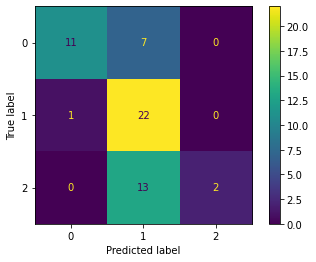

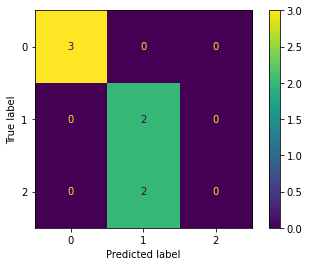

In [5]:
# Number of independent promoter library measurements
Expr_Unit = Name_Dict['Expression_Unit']
FigFontSize = Name_Dict['Figure_Font_Size']
Fig_Type = Name_Dict['Figure_Type']

for Meas_Idx in range(Measure_Numb): 
#     fig, axs = plt.subplots(nrows=1, ncols=1)
    print(Y_Col_Name[Meas_Idx])
    if Response_Value<2:
        # figure of regression plots
        plt.scatter(Y_train[:, Meas_Idx], Y_train_pred[:, Meas_Idx], marker='+')
        plt.scatter(Y_test[:, Meas_Idx], Y_test_pred[:, Meas_Idx], marker='o', c='r')
        plt.title('{} of {}'.format(ML_Regressor, Y_Col_Name[Meas_Idx]), fontsize=18)
        plt.xlabel('measured {}'.format(Expr_Unit), fontsize=FigFontSize)
        plt.ylabel('predicted {}'.format(Expr_Unit), fontsize=FigFontSize)
        plt.legend(['Training set, R$^2$={:.2f}'.format(r2_train[Meas_Idx]),'Test set, R$^2$={:.2f}'.format(r2_test[Meas_Idx])], loc='upper left', fontsize=FigFontSize)

        # saving the figure
#         Fig_ID = Name_Dict['CorrPlot_File']
        CorrPlot_File = os.path.join(Data_Folder, '{}_{}_{}_Plot_Corr-Ytrue-VS-Ypred_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Name_Dict['ML_Regressor'], Y_Col_Name[Meas_Idx].replace(' ','-'), Fig_Type))
        plt.savefig(CorrPlot_File, bbox_inches='tight', format=Fig_Type)

    else:
        # plots of confusion matrix and overall classification report
        myLabel = ['Level {}'.format(myval) for myval in range(Response_Value)]
        Measure_Name = '{}_ML'.format(Y_Col_Name[Meas_Idx])
        plot_confusion_matrix(ML_Best[Measure_Name], X_train, Y_train[:, Meas_Idx])
        # saving the figure
#         Fig_ID = Name_Dict['CorrPlot_File']
        CorrPlot_File = os.path.join(Data_Folder, '{}_{}_{}_Plot_Confusion-Train_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Name_Dict['ML_Regressor'], Y_Col_Name[Meas_Idx].replace(' ','-'), Fig_Type))
        plt.savefig(CorrPlot_File, bbox_inches='tight', format=Fig_Type)
        
        plot_confusion_matrix(ML_Best[Measure_Name], X_test, Y_test[:, Meas_Idx])
        # saving the figure
#         Fig_ID = Name_Dict['CorrPlot_File']
        CorrPlot_File = os.path.join(Data_Folder, '{}_{}_{}_Plot_Confusion-Test_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Name_Dict['ML_Regressor'], Y_Col_Name[Meas_Idx].replace(' ','-'), Fig_Type))
        plt.savefig(CorrPlot_File, bbox_inches='tight', format=Fig_Type)
        print('Training set classification report.\n',classification_report(Y_train[:, Meas_Idx], Y_train_pred[:, Meas_Idx]))
        print('Test set classification report.\n',classification_report(Y_test[:, Meas_Idx], Y_test_pred[:, Meas_Idx]))


    plt.show()

## Feature importance for tree-based methods
### Importance of GC-content for prediction 

In [6]:
if ML_Regressor in ['RF', 'GB']:
    Nr_EngFeat = len(eval(Name_Dict['Add_Feat']))
    Nucleotide_Importance = dict()
    AddFeat_Importance = dict()
    GC_Importance = np.empty((Measure_Numb,1))

    for Meas_Idx in range(Measure_Numb): 
        ML_DictName = '{}_ML_Regressor'.format(Y_Col_Name[Meas_Idx])
        Measure_Name = '{}_ML'.format(Y_Col_Name[Meas_Idx])
        #number of engineered additional features
    #     FI_DictName = '{}_FI'.format(Y_Col_Name[Meas_Idx])
    #     AddFI_DictName = '{}_FI'.format(Y_Col_Name[Meas_Idx])
        Nucleotide_Importance[Meas_Idx] = np.array(ML_Best[Measure_Name].feature_importances_[0:-Nr_EngFeat]).reshape(-1,4)
        AddFeat_Importance = ML_Best[Measure_Name].feature_importances_[-Nr_EngFeat:]
    #     print(Nucleotide_Importance)
        MeasName = '{}_FI'.format(Y_Col_Name[Meas_Idx])
    #     Feat_Nucl = [len(i) for i in Nucleotide_Importance[Measure_Numb]]
    #     Feat_All = Feat_Nucl[Meas_Idx]*4 + len(eval(Name_Dict['Add_Feat']))
        FeatList_All = np.append(np.hstack(Nucleotide_Importance[Meas_Idx]),AddFeat_Importance)
        GC_Importance[Meas_Idx] = len(FeatList_All) - np.arange(len(FeatList_All))[np.argsort(FeatList_All)==len(FeatList_All)-1]
        print('Importance of GC-content in {}: {}'.format(Y_Col_Name[Meas_Idx], GC_Importance[Meas_Idx]))
else:
    print('GC-content importance available only for decision tree methods')

Importance of GC-content in Promoter Activity: [2.]


### Sequence logo of nucleotide importance

The feature importance of the tree machiene learning methods, i.e. the y-axis in the Logo-plot, is normalized to sum over all nucleotide-positions to one.

The logos are generated with [Logomaker](https://logomaker.readthedocs.io/en/latest/).

/home/ulf/anaconda3/envs/exp2ipynb/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Importance 1: Position: -35, Nucleotide: T, FI: 0.24
Importance 2: Position: -34, Nucleotide: T, FI: 0.10
Importance 3: Position: -35, Nucleotide: A, FI: 0.10


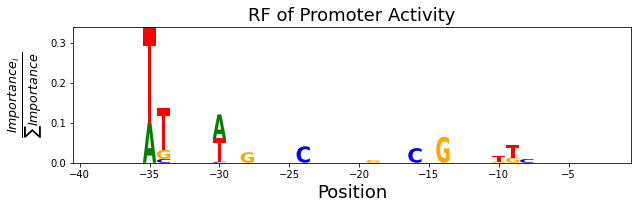

In [7]:
if ML_Regressor in ['RF', 'GB']:
    # Number of independent promoter library measurements
    for Meas_Idx in range(Measure_Numb): 
        MeasName = '{}_FI'.format(Y_Col_Name[Meas_Idx])
        PWM_tmp = pd.DataFrame(Nucleotide_Importance[Meas_Idx], columns=['A','C','G','T'])
        PWM_best = Insert_row_(Positions_removed, PWM_tmp, np.zeros([len(Positions_removed),4]))
        # extracting the 3 most important features
        TopPos, TopNuc = largest_indices(PWM_best.values, 3)
        Bases = ['A','C','G','T']
        TopNFeat = range(3)
        [print('Importance {}: Position: -{}, Nucleotide: {}, FI: {:.2f}'.format(rank+1, PWM_best.shape[0]-TopPos[rank], Bases[TopNuc[rank]], PWM_best.values[TopPos[rank],TopNuc[rank]])) for rank in TopNFeat]

        nn_logo = lm.Logo(PWM_best)
        nn_logo.ax.set_xlabel('Position', fontsize=FigFontSize)
        nn_logo.ax.set_ylabel(r'$\frac{Importance_i}{\sum Importance}$', fontsize=FigFontSize)
        nn_logo.ax.set_title('{} of {}'.format(ML_Regressor, Y_Col_Name[Meas_Idx]), fontsize=FigFontSize)

        # saving the figure
        Fig_ID = Name_Dict['LogoPlot_File']
        LogoPlot_File = os.path.join(Data_Folder, '{}_{}_{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Name_Dict['ML_Regressor'], Fig_ID, Y_Col_Name[Meas_Idx].replace(' ','-'), Fig_Type))
        plt.savefig(LogoPlot_File, bbox_inches='tight', format=Fig_Type)

        plt.show()
else:
    print('Nucleotide importance available only for decision tree methods')

In [8]:
if ML_Regressor in ['RF']:
    # Pull out one tree from the forest
    tree = ML_Best[Measure_Name][1]

    # Export the image to a dot file
    DotData = export_graphviz(tree, rounded = True, precision = 1)
    (graph, ) = pydot.graph_from_dot_data(DotData)
    Fig_ID = 'DecisionTree'
    DecTree_File = os.path.join(Data_Folder, '{}_{}_{}_{}_{}.{}'.format(time.strftime('%Y%m%d'), File_Base, Name_Dict['ML_Regressor'], Fig_ID, Y_Col_Name[Meas_Idx].replace(' ','-'), 'png'))
    graph.write_png(DecTree_File)
    # MyML.best_estimator_.get_params

In [10]:
DecTree_File

'data-Example1-Pput/20220609_Example1-Pput_RFC_DecisionTree_Promoter-Activity.png'